In [1]:
#!/usr/bin/env python

import sys
import random
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import seaborn as sns

import pandas as pd
from pandas import set_option
pd.options.mode.chained_assignment = None

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

from scipy.stats import truncnorm
from scipy.stats import pearsonr

In [2]:
class MLPlot:
    
    # Edit the font, font size, and axes width
    mpl.rcParams['font.family'] = 'Times New Roman'
    plt.rcParams['font.size'] = 24
    plt.rcParams['axes.linewidth'] = 3
    
    def __init__(self, pred, y):
        self.qm = y
        self.ml = pred
        
    # Plot outputs
    def corrplot(self):
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot()

        plt.plot(self.qm, self.ml,'ro',fillstyle='none')

        # compute pearson correlation coefficient and coefficient of determination 
        pcc, _ = pearsonr(self.qm, self.ml)
        r2 = r2_score(self.qm, self.ml)

        
        # determine the range
        qm_max=np.max(self.qm)
        qm_min=np.min(self.qm)
        ml_max=np.max(self.ml)
        ml_min=np.min(self.ml)
        sigma=np.std(self.qm)+np.std(self.ml)
        ax_low=min(qm_min,ml_min)-sigma
        ax_up=max(qm_max,ml_max)+sigma
        
        plt.xlim(ax_low,ax_up)
        plt.ylim(ax_low,ax_up)
        plt.plot([ax_low,ax_up],[ax_low,ax_up], '--b')

        plt.xlabel('QM i-RESP charge (e)')
        plt.ylabel('ML charge (e)')
        
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())
        ax.tick_params(axis='both', which='major', direction='in', length=14, width=4, color='k')
        ax.tick_params(axis='both', which='minor', direction='in', length=8, width=2, color='k')


        #ax.xaxis.grid(True, which='minor')
        # square figure
        ax.set_aspect('equal', adjustable='box')
        plt.title(f'pcc: {pcc:.2f}, R²: {r2:.2f}')

        plt.show()
    
    
    def cmplot(self):
        '''
        plot the reference and predicted data for direct comparison
        '''
        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot()
        skip = int(len(self.qm)/1000)
        plt.plot(self.qm[::skip], color='red', marker='o', linewidth=1, label = 'QM i-RESP charge (e)')
        plt.plot(self.ml[::skip], color='blue', marker='o', linewidth=1, label = 'ML charge (e)')
        plt.legend(loc='best')
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())
        ax.tick_params(axis='both', which='major', direction='in', length=14, width=4, color='k')
        ax.tick_params(axis='both', which='minor', direction='in', length=8, width=2, color='k')
        
        plt.xlabel('Index')
        plt.ylabel('Atomic charge (e)')
        plt.show()

In [3]:
# Read the data from a text file
csv = pd.read_csv('Ca_all_data.txt', delimiter=',', header=None)

In [4]:
csv.shape

(7817, 127)

In [5]:
name = list()
ele_tup=('H','C','N','O','Ca')
for i in range(1,13):
    name.append(f'deg_r{i:d}')
    name.append(f'bet_r{i:d}')
    name.append(f'clust_r{i:d}')
    name.append(f'clos_r{i:d}')
for i in ('Ca','wat'):
    name.append('deg_'+i)
    name.append('bet_'+i)
    name.append('clust_'+i)
    name.append('clos_'+i)
for cut in (2.5,3.0,3.5,4.0,4.5,5.0,5.5,6.0):
    for i in ele_tup:
        name.append(i+f'_{cut:2.1f}')
for cut in (3.0,6.0):
    for i in range(5):
        for j in range(i+1):
            name.append(ele_tup[j]+ele_tup[i]+f'_{cut:2.1f}')
name.append('Cachg')

In [6]:
csv.columns=name
csv=csv[csv.columns.drop(list(csv.filter(regex='Ca_')))]

In [7]:
csv

,deg_r1,bet_r1,clust_r1,clos_r1,deg_r2,bet_r2,clust_r2,clos_r2,deg_r3,bet_r3,...,HC_6.0,CC_6.0,HN_6.0,CN_6.0,NN_6.0,HO_6.0,CO_6.0,NO_6.0,OO_6.0,Cachg
0,0.769231,0.022146,0.800000,0.812500,0.538462,0.031784,0.761905,0.684211,0.692308,0.014973,...,2.256119,0.327246,0.457257,0.297736,0.030930,6.535074,2.742365,0.620216,4.848489,1.8556
1,0.692308,0.051158,0.666667,0.764706,0.384615,0.007717,0.900000,0.619048,0.615385,0.028148,...,1.868230,0.464060,0.334295,0.348443,0.032720,3.993562,3.243850,0.595936,4.544344,2.0247
2,0.692308,0.070883,0.583333,0.764706,0.307692,0.007372,0.833333,0.590909,0.538462,0.032824,...,1.902818,0.338521,0.252735,0.232657,0.024151,5.050111,2.785759,0.425439,4.484682,1.8851
3,0.769231,0.067837,0.644444,0.812500,0.384615,0.009844,0.800000,0.619048,0.615385,0.030800,...,2.040267,0.552729,0.395611,0.359264,0.029323,4.265185,3.191460,0.641312,4.385711,1.9071
4,0.461538,0.147192,0.533333,0.500000,0.461538,0.084219,0.666667,0.541667,0.461538,0.051313,...,0.772252,0.054393,0.089891,0.051593,0.003001,7.180609,1.049976,0.122363,4.427797,2.0212
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7812,0.692308,0.049532,0.638889,0.764706,0.384615,0.000000,1.000000,0.619048,0.538462,0.017298,...,1.916140,0.348588,0.324501,0.303118,0.033667,5.101842,2.671494,0.538040,4.373325,1.8637
7813,0.307692,0.003205,0.833333,0.342105,0.307692,0.021154,0.833333,0.419355,0.461538,0.074359,...,0.476700,0.145742,0.093675,0.080349,0.006223,6.456646,0.960649,0.169045,4.253812,1.8966
7814,0.230769,0.000000,1.000000,0.520000,0.230769,0.000000,1.000000,0.520000,0.769231,0.172272,...,1.233507,0.360294,0.150415,0.152058,0.006075,4.312474,2.303300,0.297769,4.757174,1.8748
7815,0.230769,0.000000,1.000000,0.520000,0.230769,0.000000,1.000000,0.520000,0.769231,0.171917,...,1.396941,0.347793,0.224490,0.175842,0.008748,4.953589,2.307237,0.381395,5.050580,1.8398


In [8]:
feat=csv[csv.columns[:-1]]
chg=csv[csv.columns[-1]]

In [9]:
rstate = 185054330

In [10]:
# Split the features using three categories
# all -> network + 2b + 3b
# sym -> 2b + 3b
# 2b

X_tr, X_te, y_tr, y_te = train_test_split(feat, chg, test_size=0.3, random_state=rstate)

feat_net=csv[csv.columns[:56]]
X_tr_net, X_te_net = train_test_split(feat_net, test_size=0.3, random_state=rstate)

feat_sym=csv[csv.columns[56:-1]]
X_tr_sym, X_te_sym = train_test_split(feat_sym, test_size=0.3, random_state=rstate)

feat_2b=csv[csv.columns[56:88]]
X_tr_2b, X_te_2b = train_test_split(feat_2b, test_size=0.3, random_state=rstate)

In [11]:
mpl.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 32
plt.rcParams['axes.linewidth'] = 5
plt.rcParams["figure.figsize"]=(10,10)

Using the 2b symmetry functions:
Score with the entire dataset = -0.061


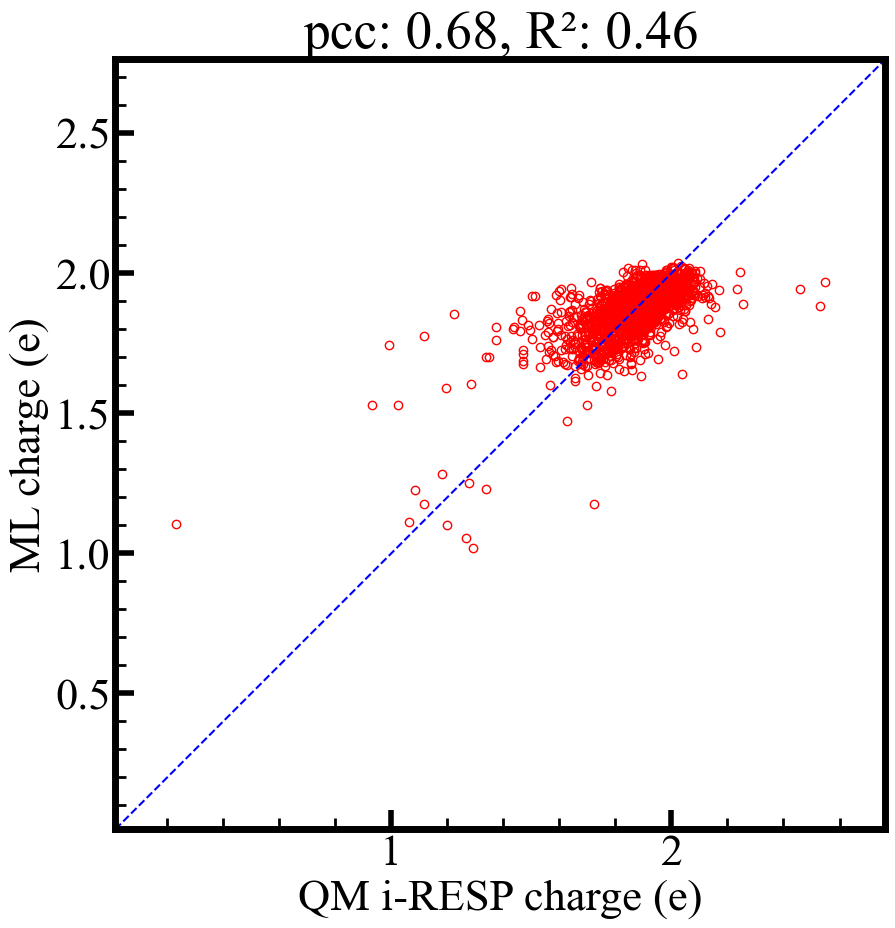

In [12]:
import xgboost as xgb
rstate=random.randrange(1,999999999,1)

estimator_2b = xgb.XGBRegressor(
    objective='reg:squarederror',
    eval_metric='mae', 
    learning_rate=0.03, 
    max_depth=5, 
    min_child_weight=0.1, 
    subsample=0.7, 
    colsample_bytree=0.7, 
    n_estimators=500,
    importance_type='gain',
    booster='gbtree',
    random_state = rstate
    )
cvscore = cross_val_score(estimator_2b, X_tr.iloc[:, :56], y_tr, cv=5, n_jobs=10, scoring='neg_mean_absolute_error')
score = cvscore.mean()
print("Using the 2b symmetry functions:")
print("Score with the entire dataset = %.3f" % score)

estimator_2b.fit(X_tr.iloc[:, :56], y_tr)
y_pred = estimator_2b.predict(X_te.iloc[:, :56])
mlplot = MLPlot(y_pred, y_te)
mlplot.corrplot()